# Sentiment Analysis of Tech News Articles

In [1]:
import pandas as pd
import nltk
import math

In [2]:
full_data = pd.read_csv("full_headline_data.csv",header=0,encoding='unicode_escape')
print(len(full_data))

4957


In [3]:
# Separate positive, negative, neutral entries
pos_lines = []
neg_lines = []
neu_lines = []
for index, row in full_data.iterrows():
    if row['rating'] == "positive":
        pos_lines.append(row['text'])
    if row['rating'] == "negative":
        neg_lines.append(row['text'])
    if row['rating'] == "neutral":
        neu_lines.append(row['text'])

In [4]:
print(len(pos_lines))
print(len(neg_lines))
print(len(neu_lines))

1429
610
2917


In [5]:
# We train on 3/4ths of the corpus,
# develop on 1/8th, and test on 1/8th

training_set = {}
dev_set = {}
test_set = {}

# First 3/4ths of corpus is the training set
training_set['pos'] = pos_lines[:(int(len(pos_lines)*3/4))]
training_set['neg'] = neg_lines[:(int(len(neg_lines)*3/4))]
training_set['neu'] = neu_lines[:(int(len(neu_lines)*3/4))]

# Next 1/8th is the dev set
dev_set['pos'] = pos_lines[(int(len(pos_lines)*3/4)):(int(len(pos_lines)*7/8))]
dev_set['neg'] = neg_lines[(int(len(neg_lines)*3/4)):(int(len(neg_lines)*7/8))]
dev_set['neu'] = neu_lines[(int(len(neu_lines)*3/4)):(int(len(neu_lines)*7/8))]

# Last 1/8th is the test set
test_set['pos'] = pos_lines[(int(len(pos_lines)*7/8)):]
test_set['neg'] = neg_lines[(int(len(neg_lines)*7/8)):]
test_set['neu'] = neu_lines[(int(len(neu_lines)*7/8)):]

print("Training set length: {}".format(((len(training_set['pos']) + len(training_set['neg']) + len(training_set['neu'])))))
print("Development set length: {}".format(((len(dev_set['pos']) + len(dev_set['neg']) + len(dev_set['neu'])))))
print("Test set length: {}".format(((len(test_set['pos']) + len(test_set['neg']) + len(test_set['neu'])))))

Training set length: 3715
Development set length: 620
Test set length: 621


In [44]:
from nltk.stem import *
from nltk.corpus import stopwords 

training_set_features = {}
dev_set_features = {}
test_set_features = {}

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english')) 

def extract(words):
    return dict([(stemmer.stem(word.lower()), True) for word in words.split() if word.lower() not in stop_words])

training_set_features['pos'] = [(extract(f), 'pos') for f in training_set['pos']]
training_set_features['neg'] = [(extract(f), 'neg') for f in training_set['neg']]
training_set_features['neu'] = [(extract(f), 'neu') for f in training_set['neu']]

dev_set_features['pos'] = [(extract(f), 'pos') for f in dev_set['pos']]
dev_set_features['neg'] = [(extract(f), 'neg') for f in dev_set['neg']]
dev_set_features['neu'] = [(extract(f), 'neu') for f in dev_set['neu']]

test_set_features['pos'] = [(extract(f), 'pos') for f in test_set['pos']]
test_set_features['neg'] = [(extract(f), 'neg') for f in test_set['neg']]
test_set_features['neu'] = [(extract(f), 'neu') for f in test_set['neu']]

In [45]:
# from nltk.classify import NaiveBayesClassifier

# train_features = training_set['pos'] + training_set['neg']
# dev_features = dev_set['pos'] + dev_set['neg']
# test_features = test_set['pos'] + test_set['neg']

# print('Training on %d instances, testing on %d instances' % (len(train_features), len(test_features)))
# classifier = NaiveBayesClassifier.train(train_features)
# print('Training complete')
# print('accuracy:', nltk.classify.util.accuracy(classifier, dev_features))
# classifier.show_most_informative_features()

from nltk.classify import NaiveBayesClassifier

training_set_features = training_set_features['pos'] + training_set_features['neg'] + training_set_features['neu']
dev_set_features = dev_set_features['pos'] + dev_set_features['neg'] + dev_set_features['neu']
test_set_features = test_set_features['pos'] + test_set_features['neg'] + test_set_features['neu']

print('Training on %d instances, testing on %d instances' % (len(training_set_features), len(test_set_features)))
classifier = NaiveBayesClassifier.train(training_set_features)
print('Training complete')
print('accuracy:', nltk.classify.util.accuracy(classifier, test_set_features))
classifier.show_most_informative_features(n=20)

Training on 3715 instances, testing on 621 instances
Training complete
accuracy: 0.7359098228663447
Most Informative Features
                    drop = True              neg : neu    =     52.6 : 1.0
                    grew = True              pos : neu    =     44.2 : 1.0
                    rose = True              pos : neu    =     42.4 : 1.0
                    warn = True              neg : neu    =     39.8 : 1.0
              strengthen = True              pos : neu    =     32.0 : 1.0
                      ep = True              neg : neu    =     29.6 : 1.0
                 decreas = True              neg : pos    =     27.3 : 1.0
              correspond = True              neg : neu    =     26.8 : 1.0
                  compar = True              neg : neu    =     25.1 : 1.0
                   doubl = True              pos : neu    =     22.5 : 1.0
                    loss = True              neg : neu    =     21.2 : 1.0
                    rise = True              pos 

In [8]:
# Checks the sentiment of a single string of text, discretely labeling it positive, negative, or neutral.
# Used for finding accuracy of our training data.
def check_sentiment_for_test(string_to_analyze):
    feature_set = extract(string_to_analyze)
    prob_dist = classifier.prob_classify(feature_set)
    scores = {'pos':prob_dist.prob('pos'),'neg':prob_dist.prob('neg'),'neu':prob_dist.prob('neu')}
    neg_neu_pos = [scores['neg'],scores['neu'],scores['pos']]
    highest_score = neg_neu_pos.index(max(neg_neu_pos))
    return_values = ["negative", "neutral", "positive"]
    return return_values[highest_score]

# Checks the sentiment of a single string of text, giving it a numerical value.
# Used for finding numerical sentiment of our newspapers. 
# When the keyword argument "return_all_scores" is true, this returns the full
# dictionary of probability scores for pos, neg, and neu. By
# default, though, it only returns the compound score.

# The compound score is just the probability of the string being positive
# minus the probability of it being negative. This indicates, in a continuous value
# between -1 and 1, the numerical value of the sentiment.
def check_sentiment(string_to_analyze, return_all_scores=False):
    feature_set = extract(string_to_analyze)
    prob_dist = classifier.prob_classify(feature_set)
    scores = {'pos':prob_dist.prob('pos'),'neg':prob_dist.prob('neg'),'neu':prob_dist.prob('neu')}
    scores['compound'] = scores['pos'] - scores['neg']
    if return_all_scores:
        return scores
    return scores["compound"]

In [9]:
check_sentiment_for_test(full_data['text'][592])

'positive'

In [16]:
wrong_pos = []
wrong_neg = []
wrong_neu = []

# Function for testing accuracy when only certain POS tags are
# considered in the sentiment analysis.
def test_POS_isolations(test_dict, tags_to_keep):
    pos_tags_to_keep = tags_to_keep
    print("Testing for: {}".format(tags_to_keep))
    test_set = test_dict
    filtered_word_list = []
    for entry in test_set['pos']:
        tokenized = nltk.word_tokenize(entry)
        tagged = nltk.pos_tag(tokenized)
        new_phrase = ""
        for word in tagged:
            if word[1] in pos_tags_to_keep:
                new_phrase += word[0] + " "
        filtered_word_list.append(new_phrase)
    pos_correct = 0
    for text in filtered_word_list:
        if check_sentiment_for_test(text) == "positive":
            pos_correct += 1
        else:
            wrong_pos.append((text,check_sentiment_for_test(text)))
    pos_score = pos_correct/len(test_set['pos'])
    print(pos_correct)
    print("Correct positive guesses: {}".format(pos_score))
    filtered_word_list = []
    for entry in test_set['neg']:
        tokenized = nltk.word_tokenize(entry)
        tagged = nltk.pos_tag(tokenized)
        new_phrase = ""
        for word in tagged:
            if word[1] in pos_tags_to_keep:
                new_phrase += word[0] + " "
        filtered_word_list.append(new_phrase)
    neg_correct = 0
    for text in filtered_word_list:
        if check_sentiment_for_test(text) == "negative":
            neg_correct += 1
        else:
            wrong_neg.append((text,check_sentiment_for_test(text)))
    neg_score = neg_correct/len(test_set['neg'])
    print(neg_correct)
    print("Correct negative guesses: {}".format(neg_score))
    filtered_word_list = []
    for entry in test_set['neu']:
        tokenized = nltk.word_tokenize(entry)
        tagged = nltk.pos_tag(tokenized)
        new_phrase = ""
        for word in tagged:
            if word[1] in pos_tags_to_keep:
                new_phrase += word[0] + " "
        filtered_word_list.append(new_phrase)
    neu_correct = 0
    for text in filtered_word_list:
        if check_sentiment_for_test(text) == "neutral":
            neu_correct += 1
        else:
            wrong_neu.append((text,check_sentiment_for_test(text)))
    neu_score = neu_correct/len(test_set['neu'])
    print(neu_correct)
    print("Correct neutral guesses: {}".format(neu_score))
    
    pos_ratio = (len(test_set['pos'])/(len(test_set['pos'])+len(test_set['neg'])+len(test_set['neu'])))
    neg_ratio = (len(test_set['neg'])/(len(test_set['pos'])+len(test_set['neg'])+len(test_set['neu'])))
    neu_ratio = (len(test_set['neu'])/(len(test_set['pos'])+len(test_set['neg'])+len(test_set['neu'])))
    
    # Precision: How many of the system's guesses were correct.
    precision = pos_score*pos_ratio + neg_score*neg_ratio + neu_score*neu_ratio
    print("Precision: {}".format(precision))
    
    # Recall: How many times the system correctly identified a string as "sentimental" (pos/neg)
    pos_ratio = (len(test_set['pos'])/(len(test_set['pos'])+len(test_set['neg'])))
    neg_ratio = (len(test_set['neg'])/(len(test_set['pos'])+len(test_set['neg'])))
    recall = pos_score*pos_ratio + neg_score*neg_ratio
    print("Recall: {}".format(recall))
    
    # F-Score
    fscore = (2*precision*recall)/(precision+recall)
    print("F-Score: {}".format(fscore))
            

In [17]:
# Testing system when it only looks at nouns
test_POS_isolations(test_set, ["NN","NNP","NNS","NNPS"])

Testing for: ['NN', 'NNP', 'NNS', 'NNPS']
116
Correct positive guesses: 0.6480446927374302
43
Correct negative guesses: 0.5584415584415584
274
Correct neutral guesses: 0.7506849315068493
Precision: 0.6972624798711755
Recall: 0.62109375
F-Score: 0.656977770567831


In [18]:
# Testing system when it only looks at adjectives
test_POS_isolations(test_set, ["JJS","JJR","JJ"])

Testing for: ['JJS', 'JJR', 'JJ']
87
Correct positive guesses: 0.4860335195530726
20
Correct negative guesses: 0.2597402597402597
296
Correct neutral guesses: 0.810958904109589
Precision: 0.6489533011272142
Recall: 0.41796875
F-Score: 0.5084573887922649


In [19]:
# Testing system when it only looks at adverbs
test_POS_isolations(test_set, ["RB","RBR","RBS","WRB"])

Testing for: ['RB', 'RBR', 'RBS', 'WRB']
16
Correct positive guesses: 0.0893854748603352
6
Correct negative guesses: 0.07792207792207792
360
Correct neutral guesses: 0.9863013698630136
Precision: 0.6151368760064412
Recall: 0.0859375
F-Score: 0.15080661079907406


In [20]:
# Testing system when it only looks at verbs
test_POS_isolations(test_set, ["VBZ","VBD","VBG","VBP","VBN","VB"])

Testing for: ['VBZ', 'VBD', 'VBG', 'VBP', 'VBN', 'VB']
97
Correct positive guesses: 0.5418994413407822
40
Correct negative guesses: 0.5194805194805194
312
Correct neutral guesses: 0.8547945205479452
Precision: 0.7230273752012882
Recall: 0.53515625
F-Score: 0.6150654181310962


In [21]:
# Testing system when it only looks at adjectives, nouns, and verbs
test_POS_isolations(test_set, ["JJS","JJR","JJ","NN","NNP","NNS","NNPS","VBZ","VBD","VBG","VBP","VBN","VB"])

Testing for: ['JJS', 'JJR', 'JJ', 'NN', 'NNP', 'NNS', 'NNPS', 'VBZ', 'VBD', 'VBG', 'VBP', 'VBN', 'VB']
146
Correct positive guesses: 0.8156424581005587
54
Correct negative guesses: 0.7012987012987013
268
Correct neutral guesses: 0.7342465753424657
Precision: 0.7536231884057971
Recall: 0.78125
F-Score: 0.7671879610504574


In [22]:
# Testing system when it only looks at adjectives, nouns, adverbs, and verbs
test_POS_isolations(test_set, ["JJS","JJR","JJ","NN","NNP","NNS","NNPS","VBZ","VBD","VBG","VBP","VBN","VB","RB","RBR","RBS","WRB"])

Testing for: ['JJS', 'JJR', 'JJ', 'NN', 'NNP', 'NNS', 'NNPS', 'VBZ', 'VBD', 'VBG', 'VBP', 'VBN', 'VB', 'RB', 'RBR', 'RBS', 'WRB']
146
Correct positive guesses: 0.8156424581005587
55
Correct negative guesses: 0.7142857142857143
274
Correct neutral guesses: 0.7506849315068493
Precision: 0.7648953301127214
Recall: 0.78515625
F-Score: 0.7748933735355348


In [407]:
for x in full_data['text'][:20]:
    print(check_sentiment(x))

-0.9125819153410697
0.16040714439276055
0.9945742153289624
-0.045905247223948856
0.00045884881792629406
-0.06488061147081584
0.713684035658864
-0.06419074849449696
0.07025035713257513
0.4272990317805506
-0.010344566634119281
0.0005162687056892947
0.9985301611331315
-0.0018917708981800582
0.07818155465650344
-0.018639690602212666
0.032182647852051306
0.00017521295629551584
0.9893340787972111
0.03573611772163661


In [23]:
#finds sentiment of each article in a given outlet
def article_sentiment(filename, filterPOS):
    list_sentiment=[]
    with open(filename) as file:
        data = file.read()
        articles = data.split("--")
        for article in articles:
            tokenized = nltk.word_tokenize(article)
            tagged = nltk.pos_tag(tokenized)
            if filterPOS:
                new_phrase = ""
                for word in tagged:
                    if filterPOS:
                        if word[1] in pos_tags_to_keep:
                            new_phrase += word[0] + " "
                list_sentiment.append(check_sentiment(new_phrase))
            else:
                list_sentiment.append(check_sentiment(article))
        return list_sentiment


In [24]:
#We will first try without any POS filtering
wsj_sentiment_raw = article_sentiment("WSJ.txt",False)
ap_sentiment_raw = article_sentiment("AP.txt",False)
nyt1_sentiment_raw = article_sentiment("NYT1.txt",False)
nyt2_sentiment_raw = article_sentiment("NYT2.txt",False)

#gets the average sentiment of the two articles
daily_score_raw=[]
summage=0
for i in range(len(wsj_sentiment_raw)):
    if i==7:
        daily_score_raw.append(0)
        summage+=(wsj_sentiment_raw[i]+ap_sentiment_raw[i]+nyt1_sentiment_raw[i]+nyt2_sentiment_raw[i])/4
    elif i%7==1 or i%7==2:
        daily_score_raw.append(0)
        summage+=(wsj_sentiment_raw[i]+ap_sentiment_raw[i]+nyt1_sentiment_raw[i]+nyt2_sentiment_raw[i])/4
    elif i%7==3 and i!=10:
        daily_score_raw.append(((wsj_sentiment_raw[i]+ap_sentiment_raw[i]+nyt1_sentiment_raw[i]+nyt2_sentiment_raw[i])/4+summage)/3) 
        summage=0
    elif i%7==3 and i==10:
        daily_score_raw.append(((wsj_sentiment_raw[i]+ap_sentiment_raw[i]+nyt1_sentiment_raw[i]+nyt2_sentiment_raw[i])/4+summage)/4) 
        summage=0
    else:
        daily_score_raw.append((wsj_sentiment_raw[i]+ap_sentiment_raw[i]+nyt1_sentiment_raw[i]+nyt2_sentiment_raw[i])/4)

    
daily_score_raw

[-0.25046518675204427,
 0,
 0,
 -0.3276732251704521,
 -0.1398721618204966,
 -0.4033507932423783,
 -0.24804574023944417,
 0,
 0,
 0,
 -0.35935813066097305,
 -0.26290498449628197,
 -0.0033266041655533774,
 -0.7973297430469115,
 -0.2665308036039439,
 0,
 0,
 -0.07577513497980932,
 -0.23687671012267908,
 -0.16709490914317904,
 -0.4948072842278529,
 -0.7266101656862034,
 0,
 0,
 -0.4519759385241029,
 -0.29464401402160684,
 -0.2527661735169947,
 -0.3429894679146513,
 -0.002044866811111823,
 0,
 0,
 -0.48160468799414113]

In [25]:
#Now we try by filtering only nouns

pos_tags_to_keep = ["NN","NNP","NNS","NNPS"]



wsj_sentiment_noun = article_sentiment("WSJ.txt",True)
ap_sentiment_noun = article_sentiment("AP.txt",True)
nyt1_sentiment_noun = article_sentiment("NYT1.txt",True)
nyt2_sentiment_noun = article_sentiment("NYT2.txt",True)
#gets the average sentiment of the two articles
daily_score_noun=[]
summage=0
for i in range(len(wsj_sentiment_noun)):
    if i==7:
        daily_score_noun.append(0)
        summage+=(wsj_sentiment_noun[i]+ap_sentiment_noun[i]+nyt1_sentiment_noun[i]+nyt2_sentiment_noun[i])/4
    elif i%7==1 or i%7==2:
        daily_score_noun.append(0)
        summage+=(wsj_sentiment_noun[i]+ap_sentiment_noun[i]+nyt1_sentiment_noun[i]+nyt2_sentiment_noun[i])/4
    elif i%7==3 and i!=10:
        daily_score_noun.append(((wsj_sentiment_noun[i]+ap_sentiment_noun[i]+nyt1_sentiment_noun[i]+nyt2_sentiment_noun[i])/4+summage)/3) 
        summage=0
    elif i%7==3 and i==10:
        daily_score_noun.append(((wsj_sentiment_noun[i]+ap_sentiment_noun[i]+nyt1_sentiment_noun[i]+nyt2_sentiment_noun[i])/4+summage)/4) 
        summage=0
    else:
        daily_score_noun.append((wsj_sentiment_noun[i]+ap_sentiment_noun[i]+nyt1_sentiment_noun[i]+nyt2_sentiment_noun[i])/4)

    
daily_score_noun



[-0.4999780785362945,
 0,
 0,
 -0.1252962036802559,
 -0.0794361018759018,
 -0.5084940843555591,
 -0.06433996175051934,
 0,
 0,
 0,
 -0.48724051111022776,
 0.07401682699926322,
 -0.2061337052553806,
 -0.9998213287668795,
 -3.6527506250136305e-05,
 0,
 0,
 -0.2829589047711973,
 -0.23464825010831655,
 0.02663421170961741,
 -0.4102802383767612,
 -0.6299751399609517,
 0,
 0,
 -0.6257967595296293,
 -0.4322599684636562,
 -0.25008339495044624,
 0.0943101104151892,
 0.16487374144719857,
 0,
 0,
 -0.22004231606582195]

In [26]:
#Now we try by filtering only adjectives

pos_tags_to_keep = ["JJS","JJR","JJ"]



wsj_sentiment_adj = article_sentiment("WSJ.txt",True)
ap_sentiment_adj = article_sentiment("AP.txt",True)
nyt1_sentiment_adj = article_sentiment("NYT1.txt",True)
nyt2_sentiment_adj = article_sentiment("NYT2.txt",True)
#gets the average sentiment of the two articles 
daily_score_adj=[]
summage=0
for i in range(len(wsj_sentiment_adj)):
    if i==7:
        daily_score_adj.append(0)
        summage+=(wsj_sentiment_adj[i]+ap_sentiment_adj[i]+nyt1_sentiment_adj[i]+nyt2_sentiment_adj[i])/4
    elif i%7==1 or i%7==2:
        daily_score_adj.append(0)
        summage+=(wsj_sentiment_adj[i]+ap_sentiment_adj[i]+nyt1_sentiment_adj[i]+nyt2_sentiment_adj[i])/4
    elif i%7==3 and i!=10:
        daily_score_adj.append(((wsj_sentiment_adj[i]+ap_sentiment_adj[i]+nyt1_sentiment_adj[i]+nyt2_sentiment_adj[i])/4+summage)/3) 
        summage=0
    elif i%7==3 and i==10:
        daily_score_adj.append(((wsj_sentiment_adj[i]+ap_sentiment_adj[i]+nyt1_sentiment_adj[i]+nyt2_sentiment_adj[i])/4+summage)/4) 
        summage=0
    else:
        daily_score_adj.append((wsj_sentiment_adj[i]+ap_sentiment_adj[i]+nyt1_sentiment_adj[i]+nyt2_sentiment_adj[i])/4)

    
print(daily_score_adj)


[-0.07150961344360388, 0, 0, 0.25494774804259146, -0.19631008486710902, 0.3522218433387053, 0.40585159953858185, 0, 0, 0, 0.21102004920373585, -0.4037214218724059, 0.19697008934476412, -0.30860475534642295, -0.5002008368376816, 0, 0, 0.2899396351478672, 0.7369143188776243, 0.6518883293659777, 0.2447662454917687, 0.4880260112286672, 0, 0, -0.415101792084196, 0.2721988111038669, 0.3285695853698666, 0.5348091801122759, -0.07311594663965987, 0, 0, -0.022747441028273196]


In [27]:
#Now we try by filtering adjectives and nouns

pos_tags_to_keep = ["JJS","JJR","JJ","NN","NNP","NNS","NNPS"]
#finds sentiment of each article in a given outlet



wsj_sentiment_adj_noun = article_sentiment("WSJ.txt",True)
ap_sentiment_adj_noun = article_sentiment("AP.txt",True)
nyt1_sentiment_adj_noun = article_sentiment("NYT1.txt",True)
nyt2_sentiment_adj_noun = article_sentiment("NYT2.txt",True)

#gets the average of the two articles based on score_dict
daily_score_adj_noun=[]
summage=0
for i in range(len(wsj_sentiment_adj_noun)):
    #good friday
    if i==7:
        daily_score_adj_noun.append(0)
        summage+=(wsj_sentiment_adj_noun[i]+ap_sentiment_adj_noun[i]+nyt1_sentiment_adj_noun[i]+nyt2_sentiment_adj_noun[i])/4
    #sat,sunday
    elif i%7==1 or i%7==2:
        daily_score_adj_noun.append(0)
        summage+=(wsj_sentiment_adj_noun[i]+ap_sentiment_adj_noun[i]+nyt1_sentiment_adj_noun[i]+nyt2_sentiment_adj_noun[i])/4
    #monday, average them
    elif i%7==3 and i!=10:
        daily_score_adj_noun.append(((wsj_sentiment_adj_noun[i]+ap_sentiment_adj_noun[i]+nyt1_sentiment_adj_noun[i]+nyt2_sentiment_adj_noun[i])/4+summage)/3) 
        summage=0
    elif i%7 and i==10:
        daily_score_adj_noun.append(((wsj_sentiment_adj_noun[i]+ap_sentiment_adj_noun[i]+nyt1_sentiment_adj_noun[i]+nyt2_sentiment_adj_noun[i])/4+summage)/4) 
        summage=0
    else:
        daily_score_adj_noun.append((wsj_sentiment_adj_noun[i]+ap_sentiment_adj_noun[i]+nyt1_sentiment_adj_noun[i]+nyt2_sentiment_adj_noun[i])/4)
print(daily_score_adj_noun)


[-0.4669920279717037, 0, 0, -0.11081884126196846, -0.24048919677796363, -0.6774194239054684, -0.06623747980214878, 0, 0, 0, -0.3336320094939768, -0.3997652355089571, -0.2971215791301582, -0.9999946366268618, -0.15674584970519465, 0, 0, -0.049712967517659655, -0.00030170894087810777, 0.22366651140850774, -0.41167331554966646, -0.5004888207483372, 0, 0, -0.6088607664649148, -0.16291838096803352, -0.4648682828834463, 0.1754867589087202, 0.18137052630425365, 0, 0, -0.47859255120228356]


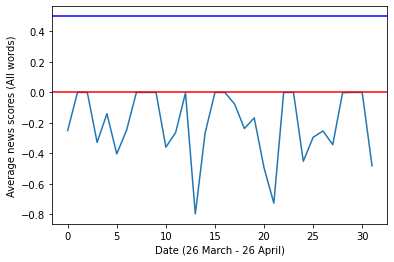

In [28]:
import matplotlib.pyplot as plt
plt.plot(daily_score_raw)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=0.5, color='b', linestyle='-')
plt.xlabel("Date (26 March - 26 April)")
plt.ylabel("Average news scores (All words)")
plt.show()

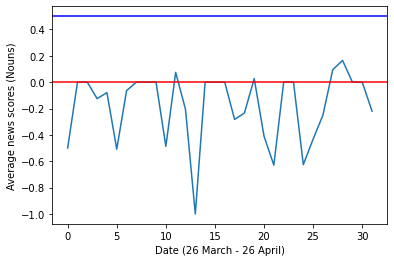

In [29]:
plt.plot(daily_score_noun)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=0.5, color='b', linestyle='-')
plt.xlabel("Date (26 March - 26 April)")
plt.ylabel("Average news scores (Nouns)")
plt.show()

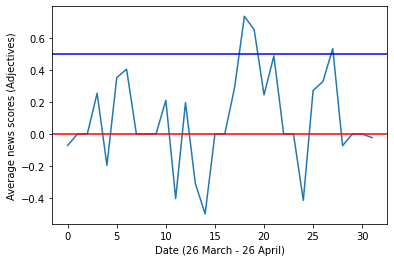

In [30]:
plt.plot(daily_score_adj)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=0.5, color='b', linestyle='-')
plt.xlabel("Date (26 March - 26 April)")
plt.ylabel("Average news scores (Adjectives)")
plt.show()

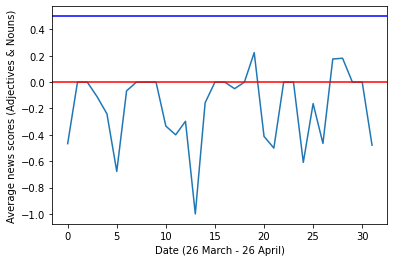

In [31]:
plt.plot(daily_score_adj_noun)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=0.5, color='b', linestyle='-')
plt.xlabel("Date (26 March - 26 April)")
plt.ylabel("Average news scores (Adjectives & Nouns)")
plt.show()

[2.2006916459458656, 0.0, 0.0, -0.7522581727676942, -0.6339814032121724, 1.656032893804064, 2.086529610309916, 0.0, 0.0, 0.0, 1.7706369374538788, -0.17988991810981766, 0.3604282102318661, 1.5222984562607222, 0.8315733896515252, 0.0, 0.0, -0.32988611074747765, 1.0769917780871636, -1.0837079965695615, 1.6998581262151151, -0.15500271254746079, 0.0, 0.0, -0.9443970089782489, -1.0134782154424813, 1.0528815706143153, -0.929625277451365, 1.4576029942803, 0.0, 0.0, 0.8105580380338783, -0.3504793320276295, -0.7913520223440577, -0.30759605859965766, -1.4381340863926368, 0.0, 0.0, -0.40059425903326545]


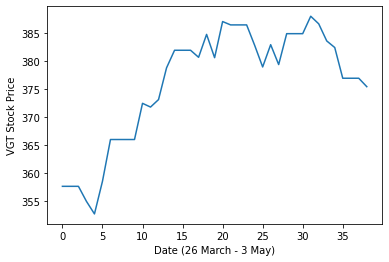

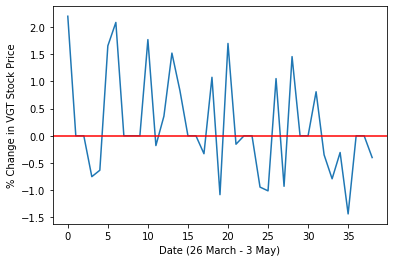

In [32]:
import numpy as np
stock_prices = []
stock = open("VGT Price.txt")
counter = 0
for line in stock:
    if counter == 0:
        counter += 1
    elif counter < 40:
        price = line.split(" ")
        stock_prices.append(float(price[1].strip("\n")))
        counter += 1
    else:
        break

#print(stock_prices)                            
delta_stock_prices = [(357.59-349.89)/349.89*100]
for i in range(len(stock_prices) - 1):
    delta_stock_prices.append((stock_prices[i+1] - stock_prices[i]) / stock_prices[i] * 100)
print(delta_stock_prices)

plt.plot(stock_prices)
plt.xlabel("Date (26 March - 3 May)")
plt.ylabel("VGT Stock Price")
plt.show()

plt.plot(delta_stock_prices)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Date (26 March - 3 May)")
plt.ylabel("% Change in VGT Stock Price")
plt.show()
    

In [33]:
#correlation

y = np.array(stock_prices[:32])
x_all = np.array(daily_score_raw)
x_adj_noun = np.array(daily_score_adj_noun)
x_adj = np.array(daily_score_adj)
x_noun = np.array(daily_score_noun)

r_all = np.corrcoef(x_all, y)
r_adj_noun = np.corrcoef(x_adj_noun, y)
r_adj = np.corrcoef(x_adj, y)
r_noun = np.corrcoef(x_noun, y)
print("Coefficient of correlation with all words:  ", r_all[0,1])
print("Coefficient of correlation using nouns & adjectives: ", r_adj_noun[0,1])
print("Coefficient of correlation using adjectives: ", r_adj[0,1])
print("Coefficient of correlation using nouns: ", r_noun[0,1])

Coefficient of correlation with all words:   -0.15243724535491324
Coefficient of correlation using nouns & adjectives:  0.03640658615114931
Coefficient of correlation using adjectives:  0.08957477256597046
Coefficient of correlation using nouns:  -0.05402209497445986


In [38]:
# ERROR ANALYSIS
wrong_pos = []
wrong_neg = []
wrong_neu = []

test_POS_isolations(test_set, ["JJS","JJR","JJ","NN","NNP","NNS","NNPS","VBZ","VBD","VBG","VBP","VBN","VB","RB","RBR","RBS","WRB"])

Testing for: ['JJS', 'JJR', 'JJ', 'NN', 'NNP', 'NNS', 'NNPS', 'VBZ', 'VBD', 'VBG', 'VBP', 'VBN', 'VB', 'RB', 'RBR', 'RBS', 'WRB']
146
Correct positive guesses: 0.8156424581005587
55
Correct negative guesses: 0.7142857142857143
274
Correct neutral guesses: 0.7506849315068493
Precision: 0.7648953301127214
Recall: 0.78515625
F-Score: 0.7748933735355348


([<matplotlib.patches.Wedge at 0x12b4d9f10>,
 [Text(-0.8923595526123416, 0.6431908183902363, 'Correct positive'),
  Text(0.42575520507322867, -1.0142645144897129, 'False negative'),
  Text(0.938447561735946, -0.5738607617461383, 'False neutral')],
 [Text(-0.4867415741521863, 0.35083135548558336, '80.1%'),
  Text(0.2322301118581247, -0.5532351897216615, '2.4%'),
  Text(0.5118804882196069, -0.3130149609524391, '17.5%')])

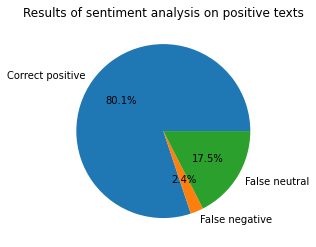

In [39]:
correct_pos = 133

false_neg = 0
false_neu = 0
for w in wrong_pos:
    if w[1] == "negative":
        false_neg += 1
    else:
        false_neu += 1

labels = ['Correct positive','False negative','False neutral']
plt.title("Results of sentiment analysis on positive texts")
plt.pie([correct_pos,false_neg,false_neu],labels=labels,autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x12b524af0>,
 [Text(-0.5790753482603683, 0.9352388684379693, 'Correct negative'),
  Text(0.30102922206955, -1.058008226556014, 'False positive'),
  Text(1.0580081913255193, -0.30102934589189706, 'False neutral')],
 [Text(-0.31585928086929177, 0.5101302918752559, '67.6%'),
  Text(0.1641977574924818, -0.5770953963032802, '23.5%'),
  Text(0.5770953770866468, -0.16419782503194383, '8.8%')])

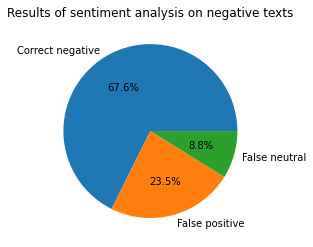

In [40]:
correct_neg = 46

false_pos = 0
false_neu = 0
for w in wrong_neg:
    if w[1] == "positive":
        false_pos += 1
    else:
        false_neu += 1

labels = ['Correct negative','False positive','False neutral']
plt.title("Results of sentiment analysis on negative texts")
plt.pie([correct_neg,false_pos,false_neu],labels=labels,autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x12b5743d0>,
 [Text(-0.753001840545898, 0.8018654676031948, 'Correct neutral'),
  Text(0.5977221931217698, -0.9234328236800455, 'False positive'),
  Text(1.0823225518588306, -0.1964125600306379, 'False negative')],
 [Text(-0.4107282766613989, 0.4373811641471971, '74.0%'),
  Text(0.3260302871573289, -0.5036906310982067, '20.3%'),
  Text(0.5903577555593621, -0.10713412365307522, '5.7%')])

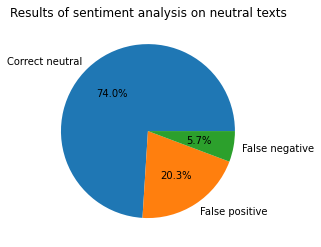

In [41]:
correct_neu = 259

false_pos = 0
false_neg = 0
for w in wrong_neu:
    if w[1] == "positive":
        false_pos += 1
    else:
        false_neg += 1

labels = ['Correct neutral','False positive','False negative']
plt.title("Results of sentiment analysis on neutral texts")
plt.pie([correct_neu,false_pos,false_neg],labels=labels,autopct='%1.1f%%')